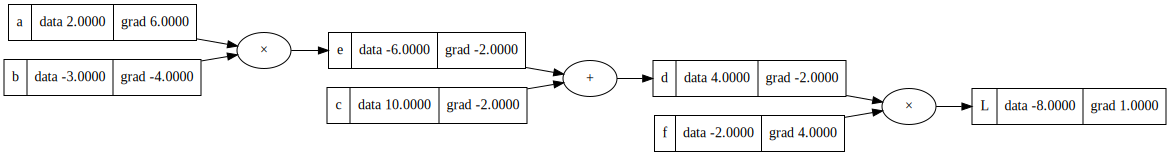

In [18]:
import sys
module_root = '..'
if module_root not in sys.path:
  sys.path.insert(0, module_root)
import os
graphviz_bin_dir = f'{os.environ["HOME"]}/.nix-profile/bin/'
if graphviz_bin_dir not in os.environ['PATH'].split(os.pathsep):
  os.environ['PATH'] += os.pathsep + graphviz_bin_dir
from numpy import r_

from importlib import reload
import minigrad.tensor as mg_tensor
reload(mg_tensor)
from minigrad.tensor import BadTensor

import minigrad.graph as mg_graph
reload(mg_graph)
from minigrad.graph import draw_dot

a = BadTensor(r_[2.], label='a')
b = BadTensor(r_[-3.], label='b')
c = BadTensor(r_[10.], label='c')
f = BadTensor(r_[-2.], label='f')
e = (a * b).label_('e')
d = (c + e).label_('d')
L = (d * f).label_('L')

L.backward()

draw_dot(L)